# ARIMA

In [4]:
# using statsmodels for this rather than sklearn, more precise, overall just better tool

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import statsmodels.tsa.ar_model
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [7]:
df = pd.read_csv('/Users/jesselemeer/Documents/GitHub/Project2-2/Project_2-2/NL_data/train_set/big_data.csv') # takes time, huge file. 

/var/folders/7x/0pnrdfvn0ts5vvq0s97bwpl80000gn/T/ipykernel_2803/355760386.py:1: DtypeWarning: Columns (18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/jesselemeer/Documents/GitHub/Project2-2/Project_2-2/NL_data/train_set/big_data.csv') # takes time, huge file.


In [5]:
forecast_df = pd.read_csv('/Users/jesselemeer/Documents/GitHub/Project2-2/Project_2-2/NL_data/forecast_set/forecast.csv') # forecast purposes, let's see

In [8]:
# due (i suppose) to the large size of the file, there was an issue with some dummy variables, we can fix it easily

# this cell allows you to get a single dataset for all the different cities we selected in the country, we use whatever variables we want

nl_df = df.copy(deep = True) # do this otherwise we have very annoying issue

nl_df['time'] = pd.to_datetime(nl_df['time'])
affected_month_columns = ['month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
df_dummies = pd.get_dummies(nl_df['time'].dt.month, prefix = 'month', dummy_na = True)
nl_df[affected_month_columns] = df_dummies[['month_6.0', 'month_7.0', 'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0']]
nl_df.set_index('time', inplace = True)
nl_df.sort_index(inplace = True)

# make some extra dummies which our models will use to situate themselves in time
nl_df['hour'] = nl_df.index.hour
nl_df['day'] = nl_df.index.day
nl_df = pd.get_dummies(nl_df, columns=['day', 'hour'], drop_first=True)

# can get all "major" cities df below
ams_df = nl_df[(nl_df['latitude'] == 52.25) & (nl_df['longitude'] == 5.)]
middelburg_df = nl_df[(nl_df['latitude'] == 51.50) & (nl_df['longitude'] == 3.5)]
hertogenbosch_df = nl_df[(nl_df['latitude'] == 51.75) & (nl_df['longitude'] == 5.5)]
maastricht_df = nl_df[(nl_df['latitude'] == 51.) & (nl_df['longitude'] == 5.75)]
utrecht_df = nl_df[(nl_df['latitude'] == 52.) & (nl_df['longitude'] == 5.)]
hague_df = nl_df[(nl_df['latitude'] == 52.) & (nl_df['longitude'] == 4.25)]
arnhem_df = nl_df[(nl_df['latitude'] == 52.) & (nl_df['longitude'] == 6.)]
lelystad_df = nl_df[(nl_df['latitude'] == 52.5) & (nl_df['longitude'] == 5.5)]
zwolle_df = nl_df[(nl_df['latitude'] == 52.5) & (nl_df['longitude'] == 6.)]
leeuwarden_df = nl_df[(nl_df['latitude'] == 53.25) & (nl_df['longitude'] == 5.75)]
assen_df = nl_df[(nl_df['latitude'] == 53.) & (nl_df['longitude'] == 6.5)]
groningen_df = nl_df[(nl_df['latitude'] == 53.25) & (nl_df['longitude'] == 6.5)]

ams_tr, ams_ts = ams_df.iloc[125000:], ams_df.iloc[125500:]
middelburg_tr, middelburg_ts = middelburg_df.iloc[125000:], middelburg_df.iloc[125500:]
hertogenbosch_tr, hertogenbosch_ts = hertogenbosch_df.iloc[125000:], hertogenbosch_df.iloc[125500:]
maastricht_tr, maastricht_ts = maastricht_df.iloc[125000:], maastricht_df.iloc[125500:]
utrecht_tr, utrecht_ts = utrecht_df.iloc[125000:], utrecht_df.iloc[125500:]
hague_tr, hague_ts = hague_df.iloc[125000:], hague_df.iloc[125500:]
arnhem_tr, arnhem_ts = arnhem_df.iloc[125000:], arnhem_df.iloc[125500:]
lelystad_tr, lelystad_ts = lelystad_df[125000:], lelystad_df[125500:]
zwolle_tr, zwolle_ts = zwolle_df[125000:], zwolle_df[125500:]
leeuwarden_tr, leeuwarden_ts = leeuwarden_df[125000:], leeuwarden_df[125500:]
assen_tr, assen_ts = assen_df[125000:], assen_df[125500:]
groningen_tr, groningen_ts = groningen_df.iloc[125000:], groningen_df.iloc[125500:]

ams_df_forecast = forecast_df[(forecast_df['latitude'] == 52.25) & (forecast_df['longitude'] == 5.)]
middelburg_df_forecast = forecast_df[(forecast_df['latitude'] == 51.50) & (forecast_df['longitude'] == 3.5)]
hertogenbosch_df_forecast = forecast_df[(forecast_df['latitude'] == 51.75) & (forecast_df['longitude'] == 5.5)]
maastricht_df_forecast = forecast_df[(forecast_df['latitude'] == 51.) & (forecast_df['longitude'] == 5.75)]
utrecht_df_forecast = forecast_df[(forecast_df['latitude'] == 52.) & (forecast_df['longitude'] == 5.)]
hague_df_forecast = forecast_df[(forecast_df['latitude'] == 52.) & (forecast_df['longitude'] == 4.25)]
arnhem_df_forecast = forecast_df[(forecast_df['latitude'] == 52.) & (forecast_df['longitude'] == 6.)]
lelystad_df_forecast = forecast_df[(forecast_df['latitude'] == 52.5) & (forecast_df['longitude'] == 5.5)]
zwolle_df_forecast = forecast_df[(forecast_df['latitude'] == 52.5) & (forecast_df['longitude'] == 6.)]
leeuwarden_df_forecast = forecast_df[(forecast_df['latitude'] == 53.25) & (forecast_df['longitude'] == 5.75)]
assen_df_forecast = forecast_df[(forecast_df['latitude'] == 53.) & (forecast_df['longitude'] == 6.5)]
groningen_df_forecast = forecast_df[(forecast_df['latitude'] == 53.25) & (forecast_df['longitude'] == 6.5)]

ams_df_forecast = ams_df_forecast.iloc[:73]
middelburg_df_forecast = middelburg_df_forecast.iloc[:73]
hertogenbosch_df_forecast = hertogenbosch_df_forecast.iloc[:73]
maastricht_df_forecast = maastricht_df_forecast.iloc[:73]
utrecht_df_forecast = utrecht_df_forecast.iloc[:73]
hague_df_forecast = hague_df_forecast.iloc[:73]
arnhem_df_forecast = arnhem_df_forecast.iloc[:73]
lelystad_df_forecast = lelystad_df_forecast.iloc[:73]
zwolle_df_forecast = zwolle_df_forecast.iloc[:73]
leeuwarden_df_forecast = leeuwarden_df_forecast.iloc[:73]
assen_df_forecast = assen_df_forecast.iloc[:73]
groningen_df_forecast = groningen_df_forecast.iloc[:73]

In [9]:
dataframes_tr = [ams_tr, middelburg_tr, hertogenbosch_tr, maastricht_tr, utrecht_tr, hague_tr, arnhem_tr, 
              lelystad_tr, zwolle_tr, leeuwarden_tr, assen_tr, groningen_tr]

dataframes_forecast = [ams_df_forecast, middelburg_df_forecast, hertogenbosch_df_forecast, maastricht_df_forecast, utrecht_df_forecast, hague_df_forecast, arnhem_df_forecast, lelystad_df_forecast, zwolle_df_forecast, leeuwarden_df_forecast, assen_df_forecast, groningen_df_forecast]

df_names = ['ams', 'middelburg', 'hertogenbosch', 'maastricht', 'utrecht', 'hague', 'arnhem', 
            'lelystad', 'zwolle', 'leeuwarden', 'assen', 'groningen']

In [10]:
X_train_df = {}
X_valid_df = {}
Y_train_df = {}
Y_valid_df = {}

for i, city in enumerate(dataframes_tr):
    df = city.copy()
    
    # now we need to drop NaNs, otherwise this simply will not work, remember shifts induce NaNs...
    df.dropna(inplace = True)
    
    # now we are ready to extract relevant variables from the dataset
    city_train = pd.DataFrame()
    city_valid = pd.DataFrame()

    train_size = round(len(df) * 0.8) # this gets the size of the train set, so we can make a train-valid split sequentially

    city_train = df.iloc[:train_size]
    city_valid = df.iloc[train_size:]

    Y_train = city_train['t2m'] # obviously here you only want the target, not more not less
    Y_valid = city_valid['t2m']

    Y_valid = Y_valid.values
    Y_train = Y_train.values
    Y_train, Y_valid = Y_train.reshape(-1, 1), Y_valid.reshape(-1, 1)
    
    scaler = MinMaxScaler()
    Y_train_scaled, Y_valid_scaled = scaler.fit_transform(Y_train), scaler.fit_transform(Y_valid)

    Y_train_df[df_names[i]] = Y_train
    Y_valid_df[df_names[i]] = Y_valid_scaled

         Current function value: nan
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/Users/jesselemeer/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  562
Model:             SARIMAX(6, 0, 1)x(1, 1, [1, 2], 24)   Log Likelihood                -536.415
Date:                                 Thu, 13 Jun 2024   AIC                           1094.831
Time:                                         15:24:42   BIC                           1141.997
Sample:                                              0   HQIC                          1113.280
                                                 - 562                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9693      0.979      0.990      0.322      -0.949       2

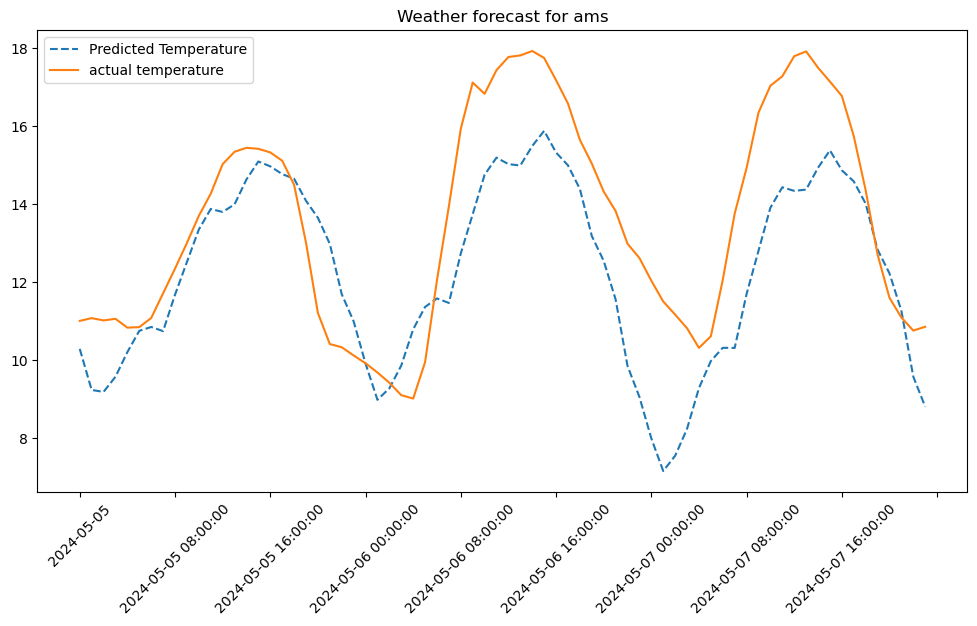

In [42]:
# we might wanna get this thing with less data, right now it's a disaster in terms of how slow it trains
# larger seasonal orders make it unbelievably slow, we're on 24, with 100k datapoints, it takes most likely a couple of hours to fit now

forecast_horizon = 72 # 24 hours forecast, let's see what happens

predictions_dict = {} # store model predictions, according to the same keys as before, 'ams', etc ...
forecast_dict = {} 

special = ['ams']
for idx, i in enumerate(special):

    # X_train = X_train_df[i]
    Y_train = Y_train_df[i]
    # X_valid = X_valid_df[i]
    Y_valid = Y_valid_df[i]

    real_test = dataframes_forecast[idx]['t2m'][:-1].values

    timeindex = dataframes_forecast[idx]['time'][:-1]

    # assume 6 lags, it means we assume weather depends on 6 past hours. 
    model = SARIMAX(Y_train, order=(6, 0, 1), 
                    seasonal_order=(1, 1, 2, 24), 
                    exog = None).fit(method='cg')

    # we can print model summary to see which lags are significant
    print(model.summary())

    forecasts = model.forecast(steps=forecast_horizon)
    forecast_dict[i] = forecasts
    
    # Store predictions and actual values in a dictionary
    predictions_dict[i] = pd.Series(forecasts, index=timeindex)
    actual_values = pd.Series(real_test, index=timeindex)

    plot_title = str(f"Weather forecast for {i}")
    

    plt.figure(figsize=(12, 6))
    plt.plot(timeindex, forecasts- 273.15, label='Predicted Temperature', linestyle='--')
    plt.plot(timeindex, real_test- 273.15, label = 'actual temperature')
    plt.legend()
    plt.title(plot_title)

    # Group x-axis labels (dates)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Adjust the number of ticks as needed
    
    plt.show()

    


    from sklearn.metrics import mean_squared_error, mean_absolute_error

    # mse = mean_squared_error(Y_valid, y_pred)
    # mae = mean_absolute_error(Y_valid, y_pred)

    # print(f'Mean Squared Error: {mse}')
    # print(f'Mean Absolute Error: {mae}')

In [45]:
# save the arima model
import os
import pickle

save_dir = os.path.join("/Users/jesselemeer/Documents/GitHub/Project2-2/Project_2-2/Python/SARIMAX/my_dir/models", 'ams')

# if the dir does not exist, create it
os.makedirs(save_dir, exist_ok=True)

with open(os.path.join(save_dir, 'sarimax_model.pkl'), 'wb') as f:
    pickle.dump(model, f)

In [29]:
def predict_temp(date, location):
    if location in predictions_dict and date in predictions_dict[location].index:
        prediction = predictions_dict[location][date] - 273.15
        actual = actual_values[date] - 273.15
        return prediction, actual
    else:
        return None, None

In [43]:
#test method
date_to_predict = '2024-05-05 08:00:00'  #'2024-01-01 00:00:00' is the format
location = 'ams'
prediction, actual = predict_temp(date_to_predict, location)
print(f"Prediction for {date_to_predict} in {location}: {prediction} °C")
print(f"Actual value for {date_to_predict} in {location}: {actual} °C")

Prediction for 2024-05-05 08:00:00 in ams: 11.677771050187857 °C
Actual value for 2024-05-05 08:00:00 in ams: 12.346830000000011 °C
